<a href="https://colab.research.google.com/github/VidhanA-01/Visual-Saliency/blob/main/Visual_Saliency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')
#Various paths from where I will import the data
image_paths='/content/drive/My Drive/DATA_VisualSaliency/ALLSTIMULI/ALLSTIMULI'
fixation_data='/content/drive/MyDrive/DATA_VisualSaliency/ALLFIXATIONMAPS/ALLFIXATIONMAPS'
test_paths='/content/drive/MyDrive/DATA_VisualSaliency/BenchmarkIMAGES (1)/BenchmarkIMAGES'

Mounted at /content/drive


In [2]:
#getting a list of image path in the folder
import os
training_path = os.listdir(image_paths)
fixation_path = os.listdir(fixation_data)
test_path = os.listdir(test_paths)
print(fixation_path)
print(training_path)
print(test_path)

['i2140171593_fixPts.jpg', 'i2133522539_fixMap.jpg', 'i2145581941_fixMap.jpg', 'i2132553812_fixMap.jpg', 'i2145018847_fixPts.jpg', 'i2139086685_fixMap.jpg', 'i2141160962_fixPts.jpg', 'i2134841990_fixPts.jpg', 'i2145575787_fixMap.jpg', 'i2139086685_fixPts.jpg', 'i2133522539_fixPts.jpg', 'i2132410530_fixMap.jpg', 'i2135366103_fixMap.jpg', 'i2145105890_fixMap.jpg', 'i2132410530_fixPts.jpg', 'i2145018847_fixMap.jpg', 'i2140171593_fixMap.jpg', 'i2132553812_fixPts.jpg', 'i2145105890_fixPts.jpg', 'i2148681608_fixPts.jpg', 'i2155229819_fixPts.jpg', 'i2147039741_fixPts.jpg', 'i2152854053_fixMap.jpg', 'i2147250639_fixMap.jpg', 'i2156407718_fixPts.jpg', 'i2155306779_fixPts.jpg', 'i2155595511_fixMap.jpg', 'i2152854053_fixPts.jpg', 'i2158540867_fixPts.jpg', 'i2160369496_fixMap.jpg', 'i2148436990_fixPts.jpg', 'i2147250639_fixPts.jpg', 'i2155595511_fixPts.jpg', 'i2166923001_fixMap.jpg', 'i2160369496_fixPts.jpg', 'i2166923001_fixPts.jpg', 'i2147039741_fixMap.jpg', 'i2154989221_fixPts.jpg', 'i215508473

In [3]:
#Importing various libraries to perform functionalities
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [4]:
# Made a Training DataLoader without labels 
import os
import pandas as pd
import scipy.io 
from torchvision.io import read_image
import torchvision.transforms as T

class CustomImageDataset(Dataset):
    def __init__(self,training_path, transform=None, target_transform=None):
        self.training_path = training_path
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.training_path)

    def __getitem__(self, idx):
        image = read_image(image_paths +'/'+ training_path[idx])
        path_convert = fixation_data +'/'+ os.path.splitext(training_path[idx])[0]+'_fixMap.jpg'
        fixation = read_image(path_convert)
        trans = T.Resize(size=(224,224))
        image = trans(image)
        fixation = trans(fixation)
        if self.transform:
            image = self.transform(image)
            fixation = self.transform(fixation)
        return image,fixation

In [5]:
# Made a Test DataLoader 
import os
import pandas as pd
import scipy.io 
from torchvision.io import read_image
import torchvision.transforms as T

class CustomImageDataset_test(Dataset):
    def __init__(self,test_path, transform=None, target_transform=None):
        self.test_path = test_path
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.test_path)

    def __getitem__(self, idx):
        image = read_image(test_paths +'/'+ test_path[idx])
        trans = T.Resize(size=(224,224))
        image = trans(image)
        if self.transform:
            image = self.transform(image)
        return image

In [6]:
#Calling 
training_data = CustomImageDataset(training_path)
test_data = CustomImageDataset_test(test_path)

In [7]:
from torch.utils.data import DataLoader
#making a Dataloader to make the object iterable
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 3, 224, 224])


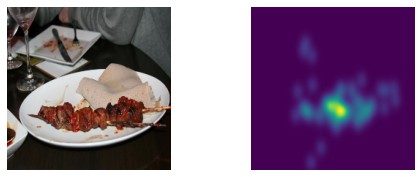

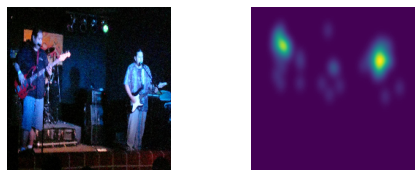

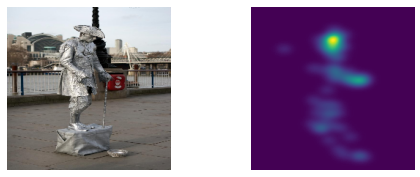

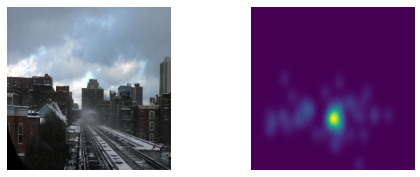

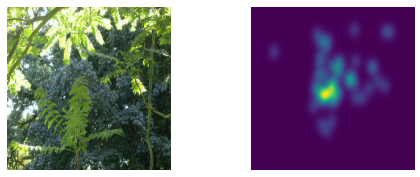

In [8]:
# Displaying image
import random
train_features,fix_features = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
for i in range(5):
  n= random.randint(0,64)
  img = train_features[n].squeeze()
  fix = fix_features[n].squeeze()
  f, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
  axs[0].imshow(img.permute(1,2,0))
  axs[0].set_axis_off()
  axs[1].imshow(fix)  
  axs[1].set_axis_off()

In [9]:
batch_size = 64
n_iters = 1000
num_epochs = n_iters / (len(training_data) / batch_size)
num_epochs = int(num_epochs)

In [10]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import glob
from torchvision.io import read_image
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()

        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2,return_indices=True)

        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()

        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2,return_indices=True)
        # Upsampling 
        self.unpool = nn.MaxUnpool2d(kernel_size=2)
        # Convolution 3
        self.cnn3 = nn.Conv2d(in_channels=32,out_channels=16,kernel_size=5,stride=1,padding=2)
        self.unpool = nn.MaxUnpool2d(kernel_size=2)
        self.cnn4 = nn.Conv2d(in_channels=16,out_channels=1,kernel_size=5,stride=1,padding=2)


    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)

        # Max pool 1
        out,indices1 = self.maxpool1(out)

        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)

        # Max pool 2 
        out,indices2 = self.maxpool2(out)
        out = self.unpool(out, indices2, output_size=(out.size(0),32,112,112))
        out = self.cnn3(out)
        out = self.unpool(out, indices1, output_size=(out.size(0),16,224,224))
        out = self.cnn4(out)



        return out


In [11]:
from torchsummary import summary 
DEVICE = 'cuda'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNNModel()
model.to(device)
summary(model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]           1,216
              ReLU-2         [-1, 16, 224, 224]               0
         MaxPool2d-3  [[-1, 16, 112, 112], [-1, 16, 112, 112]]               0
            Conv2d-4         [-1, 32, 112, 112]          12,832
              ReLU-5         [-1, 32, 112, 112]               0
         MaxPool2d-6  [[-1, 32, 56, 56], [-1, 32, 56, 56]]               0
       MaxUnpool2d-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 16, 112, 112]          12,816
       MaxUnpool2d-9         [-1, 16, 224, 224]               0
           Conv2d-10          [-1, 1, 224, 224]             401
Total params: 27,265
Trainable params: 27,265
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 384130.52
Param

In [12]:
DEVICE = 'cuda'
#STEP 4: INSTANTIATE MODEL CLASS


model = CNNModel()

#######################
#  USE GPU FOR MODEL  #
#######################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()


'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
optimizer = torch.optim.Adam(model.parameters(),lr=0.001,betas=(0.9,0.999))

'''
STEP 7: TRAIN THE MODEL
'''
iter = 0
for epoch in range(num_epochs):
    for i,(images, labels) in enumerate(train_dataloader):

        #######################
        #  USE GPU FOR MODEL  #
        #######################
         # rescale to match image size
        #images = images[0].squeeze()
        #images = images.permute(1,2,0)
        image_tensor = torch.tensor(images,dtype=torch.float32)
        #print(image_tensor.shape)
        #labels = torch.squeeze(labels,dim=0)
        #label = label.permute(1,2,0)
        label_tensor = torch.tensor(labels,dtype=torch.float32).to(device)
        #print(label_tensor.shape)


        image_tensor = image_tensor.requires_grad_().to(device)
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(image_tensor)
        #print(outputs.shape)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, label_tensor)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [13]:
path = './model01'
torch.save(model,path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


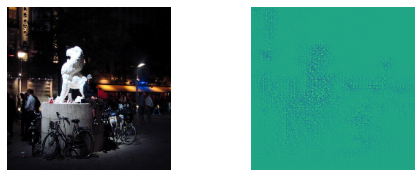

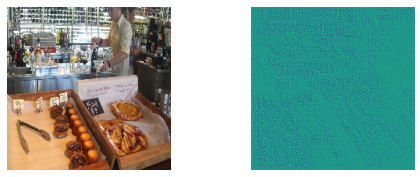

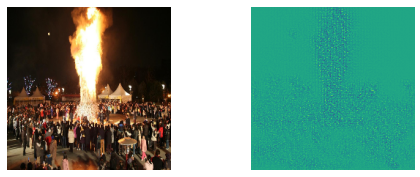

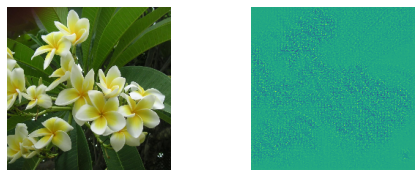

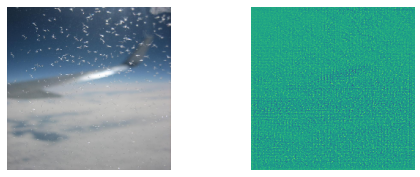

In [14]:
model = torch.load(path)
#Testing the model
iter=0
for i,(images) in enumerate(test_dataloader):
  iter+=1
  image_tensor = torch.tensor(images,dtype=torch.float32)
  image_tensor = image_tensor.requires_grad_().to(device)
  outputs=model(image_tensor)
  if iter%1==0:
    img = image_tensor[0].squeeze().to('cpu')
    img = img.permute(1,2,0)
    img = img.detach().numpy()
    fix = outputs[0].squeeze()
    fix = fix.to('cpu').detach().numpy()
    f, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
    axs[0].imshow(img.astype('uint8'))
    axs[0].set_axis_off()
    axs[1].imshow(fix)  
    axs[1].set_axis_off()